In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_pde, plot_losses, l2
from modules.problems import Diffusion

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [84]:
def train(
    problem,
    model,
    N_LB, N_RB, N_I, N_D,
    coef, lr, num_iters,
    print_every=1000, collect_every=1000
):
    x_sampled = torch.tensor(np.random.uniform(problem.L, problem.R, N_I), dtype=torch.float32)
    t_left_sampled =  torch.tensor(np.random.uniform(0, problem.T, N_LB), dtype=torch.float32)
    t_right_sampled = torch.tensor(np.random.uniform(0, problem.T, N_RB), dtype=torch.float32)
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values]
            return values
    
    problem.left_values =  problem.left_boundary [nearest_index(problem.t, t_left_sampled) ]
    problem.right_values = problem.right_boundary[nearest_index(problem.t, t_right_sampled)]
    problem.init_values =  problem.initial_values[nearest_index(problem.x, x_sampled)      ]

    x_pts = torch.tensor(np.random.uniform(problem.L, problem.R, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    t_pts = torch.tensor(np.random.uniform(0, problem.T, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)

    test_points = torch.cartesian_prod(problem.x, problem.t)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_B, L_I = problem.loss_boundary(model, t_left_sampled, t_right_sampled, x_sampled)
        L_D = problem.loss_physical(model, x_pts, t_pts)

        total = coef * (L_B + L_I) + (1 - coef) * L_D

        total.backward()
        optimizer.step()
                
        if i % collect_every == 0:
            with torch.no_grad():
                preds = model(test_points).reshape(problem.Nx, problem.Nt).detach().numpy()
                error = l2(preds.T, problem.solution)
                
                losses.append(np.array([L_I.item(), L_B.item(), L_D.item(), total.item()]))
                errors.append(error)
                
        if i % print_every == 0:
            print(f'Iteration {i} --- Loss {total.item()} --- L2 {error}')
                
    return np.array(losses), np.array(errors)

In [ ]:
D = 0.5
L, R, T = 0, 1, 0.5
Nt, Nx = 500, 250
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(2 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

In [ ]:
D = 0.1
L, R, T = -2, 2, 40
Nt, Nx = 500, 150
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(0.5 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

In [ ]:
L, W = 2, 32
model = FeedForwardNetwork(L, W, input_dim=2, output_dim=1)
model.init_weights(init.kaiming_normal_)

N_I, N_LB, N_RB, N_D = 42, 12, 12, 1024
coef = 0.8
lr = 1e-3
num_iters = 2500
collect_every = 250

losses, errors = train(
    problem,
    model,
    N_LB, N_RB, N_I, N_D,
    coef=coef, lr=lr, num_iters=num_iters,
    collect_every=collect_every, print_every=500
)

In [ ]:
test_points = torch.cartesian_prod(problem.x, problem.t)
predictions = model(test_points).reshape(Nx, Nt).detach().numpy()
plot_pde(problem.x, problem.t, predictions.T, size=(6.5, 3))

In [ ]:
test_points = torch.cartesian_prod(problem.x, problem.t)
predictions = model(test_points).reshape(Nx, Nt).detach().numpy()
plot_pde(problem.x, problem.t, predictions.T - problem.solution, size=(6.5, 3))

In [ ]:
plot_pde(problem.x, problem.t, np.abs(predictions.T - problem.solution), size=(6.5, 3))

In [ ]:
plt.style.use(['grid'])

plot_losses(
    np.arange(0, num_iters+1, collect_every),
    losses=[
        (losses[:,0], r'$L_\mathcal{I}$'),
        (losses[:,1], r'$L_\mathcal{B}$'),
        (losses[:,2], r'$L_\mathcal{D}$'),
        (losses[:,3], r'$L_\mathcal{T}$')
    ],
    errors=[
        (errors, r'L2'),
    ]
)

## Interesting problem statements
---

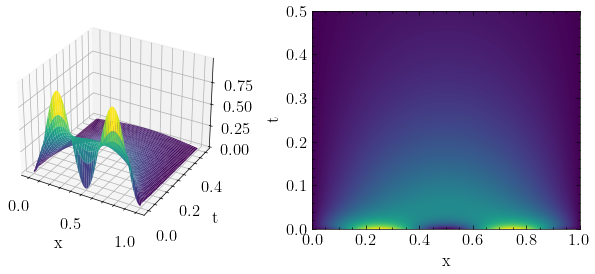

In [3]:
# Default

D = 0.5
L, R, T = 0, 1, 0.5
Nt, Nx = 500, 150
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(2 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

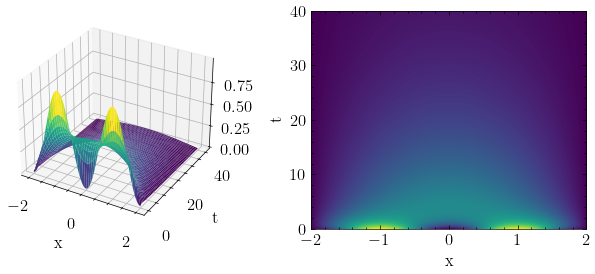

In [22]:
# Solution is visually indistinguishable from default, but parameters have changed.
# Will hyperparameters change too?

D = 0.1
L, R, T = -2, 2, 40
Nt, Nx = 500, 150
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(0.5 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

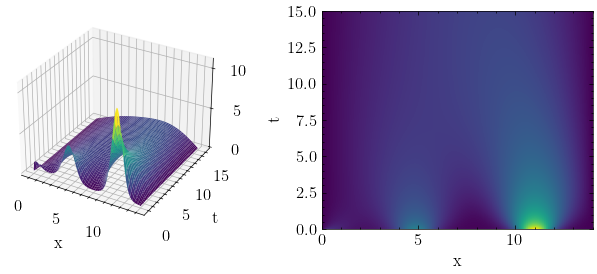

In [21]:
# Solution with two concentration peaks (plus one small on the left).

def f(x):
    return torch.exp(torch.sin(x)*torch.log(1/(x + np.finfo(float).eps)))

D = 0.4
L, R, T = 0, 14, 15
Nt, Nx = 500, 150
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = f(torch.linspace(L, R, Nx))

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

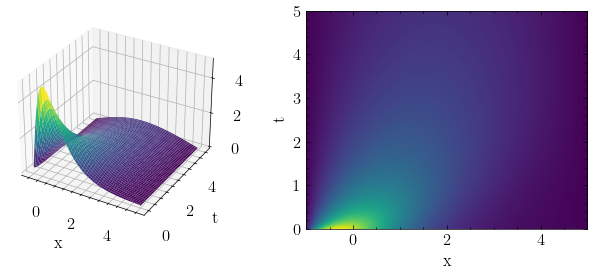

In [4]:
# Simple heat transfer with constant cold boundaries.

D = 0.7
L, R, T = -1, 5, 5
Nt, Nx = 500, 250
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(torch.exp(-torch.linspace(L, R, Nx) + 0.145))*5

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

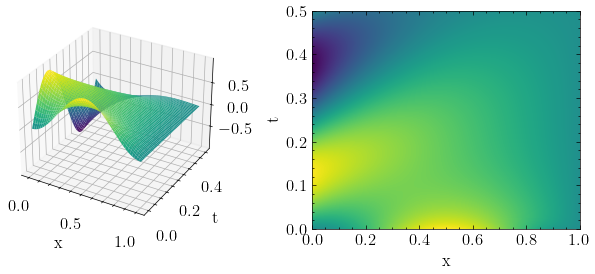

In [2]:
# Heat transfer with periodic boundary.

D = 0.5
L, R, T = 0, 1, 0.5
Nt, Nx = 500, 750
left_boundary = torch.sin(4 * torch.pi * torch.linspace(0, T, Nt))
right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

In [2]:
def get_problem(N):
    match N:
        case 1:
            D = 0.5
            L, R, T = 0, 1, 0.5
            Nt, Nx = 500, 150
            left_boundary = right_boundary = torch.zeros(Nt)
            initial_conditions = torch.sin(2 * np.pi * torch.linspace(L, R, Nx)) ** 2
            
        case 2:
            D = 0.1
            L, R, T = -2, 2, 40
            Nt, Nx = 500, 150
            left_boundary = right_boundary = torch.zeros(Nt)
            initial_conditions = torch.sin(0.5 * np.pi * torch.linspace(L, R, Nx)) ** 2
            
        case 3:
            def f(x):
                return torch.exp(torch.sin(x)*torch.log(1/(x + np.finfo(float).eps)))
            D = 0.4
            L, R, T = 0, 14, 15
            Nt, Nx = 500, 150
            left_boundary = right_boundary = torch.zeros(Nt)
            initial_conditions = f(torch.linspace(L, R, Nx))
            
        case 4:
            D = 0.7
            L, R, T = -1, 5, 5
            Nt, Nx = 500, 250
            left_boundary = right_boundary = torch.zeros(Nt)
            initial_conditions = torch.sin(torch.exp(-torch.linspace(L, R, Nx) + 0.145))*5
            
        case 5:
            D = 0.5
            L, R, T = 0, 1, 0.5
            Nt, Nx = 500, 750
            left_boundary = torch.sin(4 * torch.pi * torch.linspace(0, T, Nt))
            right_boundary = torch.zeros(Nt)
            initial_conditions = torch.sin(np.pi * torch.linspace(L, R, Nx)) ** 2
            
    problem = Diffusion(
        D, (L, R, T), (Nt, Nx),
        (left_boundary, right_boundary, initial_conditions)
    )
    return problem

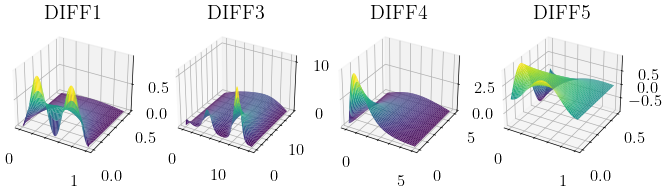

In [39]:
inds = [1, 3, 4, 5]
problems = [get_problem(i) for i in inds]
indexes = [141, 142, 143, 144]

size = (6.7, 1.8)
fig = plt.figure(figsize=size)

for i, index, problem in zip(inds, indexes, problems):
    X, T = np.meshgrid(problem.x, problem.t)
    ax = fig.add_subplot(index, projection='3d')
    ax.plot_surface(X, T, problem.solution, cmap='viridis')
    ax.title.set_text(f'DIFF{i}')
plt.tight_layout()

plt.savefig('../images/diff_grid.png', dpi=250)
plt.show()

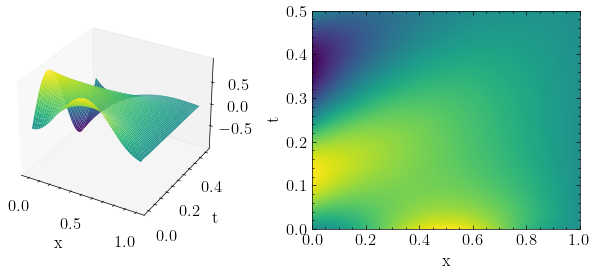

In [12]:
problem = get_problem(5)
test_model = torch.load('./studies/diff_5_best_model.pt', map_location='cpu')

test_points = torch.cartesian_prod(problem.x, problem.t)
predictions = test_model(test_points).reshape(problem.Nx, problem.Nt).detach().numpy()
plot_pde(problem.x, problem.t, predictions.T, size=(6.5, 3))

## Hyperparameters tuning
---

In [10]:
import optuna

best_model = None
model = None

def get_pts(problem, N_I, N_LB, N_RB, N_D, sampling):
    if sampling == 'random':
        x_sampled = torch.tensor(np.random.uniform(problem.L, problem.R, N_I), dtype=torch. float32, requires_grad=True)
        t_left_sampled =  torch.tensor(np.random.uniform(0, problem.T, N_LB), dtype=torch.float32, requires_grad=True)
        t_right_sampled = torch.tensor(np.random.uniform(0, problem.T, N_RB), dtype=torch.float32, requires_grad=True)
        
        x_pts = torch.tensor(np.random.uniform(problem.L, problem.R, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
        t_pts = torch.tensor(np.random.uniform(0, problem.T, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
        
    else:
        x_sampled = torch.linspace(problem.L, problem.R, N_I, requires_grad=True)
        t_left_sampled =  torch.linspace(0, problem.T, N_LB, requires_grad=True)
        t_right_sampled = torch.linspace(0, problem.T, N_RB, requires_grad=True)
        
        k = np.sqrt(problem.Nt * problem.Nx / N_D)
        nt, nx = int(problem.Nt / k), int(problem.Nx / k)
        x_pts, t_pts = [
            pts.reshape(-1, 1) for pts in torch.meshgrid(
            torch.linspace(problem.L, problem.R, nx, requires_grad=True).to(device),
            torch.linspace(0, problem.T, nt, requires_grad=True).to(device),
            indexing='ij'
        )]
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values.detach().numpy()]
            return values
    
    problem.left_values =  problem.left_boundary [nearest_index(problem.t, t_left_sampled) ].to(device)
    problem.right_values = problem.right_boundary[nearest_index(problem.t, t_right_sampled)].to(device)
    problem.init_values =  problem.initial_values[nearest_index(problem.x, x_sampled)      ].to(device)

    return x_sampled.to(device), t_left_sampled.to(device), t_right_sampled.to(device), x_pts.to(device), t_pts.to(device)

def objective(trial):
    
    global model
    
    L = trial.suggest_int('L', 2, 8, step=2)
    W = trial.suggest_int('W', 32, 64, step=16)
    model = FeedForwardNetwork(L, W, input_dim=2, output_dim=1).to(device)
    
    init_rule = trial.suggest_categorical(
        'initialization', 
        ['default', 'eye', 'normal', 'xavier', 'kaiming', 'orthogonal']
    )
    if init_rule == 'eye':
        model.init_weights(init.eye_)
    elif init_rule == 'normal': 
        model.init_weights(init.normal_)
    elif init_rule == 'xavier':
        model.init_weights(init.xavier_normal_)
    elif init_rule == 'kaiming':
        model.init_weights(init.kaiming_normal_)
    elif init_rule == 'orthogonal':
        model.init_weights(init.orthogonal_)
    
    N_I = trial.suggest_int('N_I', 24, problem.Nx // 2)
    N_LB = trial.suggest_int('N_LB', 12, problem.Nt // 2)
    N_RB = trial.suggest_int('N_RB', 12, problem.Nt // 2)
    N_D = trial.suggest_int('N_D', 128, 1024*5, log=True)
    sampling = trial.suggest_categorical('sampling', ['random', 'grid'])
    
    while True:
        try:
            x_sampled, t_left_sampled, t_right_sampled, x_pts, t_pts = get_pts(
                problem, N_I, N_LB, N_RB, N_D, sampling
            )
        except:
            print('Error in generating points... Trying again...')
        else:
            break
    
    coef = trial.suggest_float('coef', 0.05, 0.95)
    
    lr = trial.suggest_float('lr', 1e-5, 1.0, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    test_points = torch.cartesian_prod(problem.x, problem.t).to(device)

    for i in range(5000):

        optimizer.zero_grad()

        L_B, L_I = problem.loss_boundary(model, t_left_sampled, t_right_sampled, x_sampled)
        L_D = problem.loss_physical(model, x_pts, t_pts)

        total = coef * (L_B + L_I) + (1 - coef) * L_D

        total.backward()
        optimizer.step()
        
        if (i + 1) % 500 == 0:
            with torch.no_grad():
                preds = model(test_points).reshape(problem.Nx, problem.Nt).detach().cpu().numpy()
                error = l2(preds.T, problem.solution)
            
            trial.report(error, i + 1)
            
            if trial.should_prune():
                raise optuna.TrialPruned()
        
    return error

def callback(study, trial):
    global best_model
    
    if study.best_trial == trial:
        best_model = model

In [12]:
for problem_number in range(1, 6):
    problem = get_problem(problem_number)

    study = optuna.create_study(
        study_name=f'diff_{problem_number}',
        direction='minimize', 
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(max_resource=5000)
        )

    study.optimize(objective, n_trials=50, callbacks=[callback])
    study.trials_dataframe().to_csv(f'./studies/{study.study_name}.csv', sep=',')
        
    torch.save(best_model, f'./studies/{study.study_name}_best_model.pt')

[I 2024-04-02 12:00:01,361] A new study created in memory with name: diff_1
[I 2024-04-02 12:02:38,370] Trial 0 finished with value: 40.91490629347666 and parameters: {'L': 8, 'W': 48, 'initialization': 'normal', 'N_I': 47, 'N_LB': 153, 'N_RB': 83, 'N_D': 711, 'sampling': 'grid', 'coef': 0.2127340752208156, 'lr': 0.42846309537087685}. Best is trial 0 with value: 40.91490629347666.
[I 2024-04-02 12:02:43,636] Trial 1 pruned. 
[I 2024-04-02 12:03:37,419] Trial 2 finished with value: 13.43028610306943 and parameters: {'L': 2, 'W': 64, 'initialization': 'eye', 'N_I': 50, 'N_LB': 31, 'N_RB': 97, 'N_D': 2112, 'sampling': 'grid', 'coef': 0.7598905835368305, 'lr': 0.00013051912086332244}. Best is trial 2 with value: 13.43028610306943.
[I 2024-04-02 12:04:31,238] Trial 3 finished with value: 27.717028377646905 and parameters: {'L': 2, 'W': 64, 'initialization': 'xavier', 'N_I': 67, 'N_LB': 221, 'N_RB': 22, 'N_D': 206, 'sampling': 'grid', 'coef': 0.8570620372648803, 'lr': 0.007969077738458412}. 

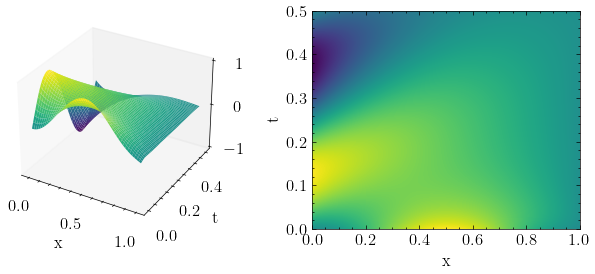

In [7]:
test_model = torch.load('./studies/diff_5_best_model.pt')
test_points = torch.cartesian_prod(problem.x, problem.t)
preds = test_model(test_points).reshape(problem.Nx, problem.Nt).detach().numpy()
plot_pde(problem.x, problem.t, preds.T, size=(6.5, 3))

## Hyperparameters analysis
---

In [43]:
import pandas as pd
from datetime import datetime
from modules.utils import get_corr, plot_rmse_corr

In [53]:
new_names = ['l2', 'duration', 'L', 'N_D', 'N_I', 'N_LB', 'N_RB', 'W', 'coef', 'init', 'lr', 'sampling', 'state']

def convert(duration):
    pt = datetime.strptime(duration[duration.find('days')+5:],'%H:%M:%S.%f')
    return pt.second + pt.minute*60 + pt.hour*3600

rung = [f'system_attrs_completed_rung_{i}' for i in range(8)]
diff1 = pd.read_csv('./studies/diff_1.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rung, axis=1)
diff2 = pd.read_csv('./studies/diff_2.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rung, axis=1)
diff3 = pd.read_csv('./studies/diff_3.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rung, axis=1)
diff4 = pd.read_csv('./studies/diff_4.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rung, axis=1)
diff5 = pd.read_csv('./studies/diff_5.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete'] + rung, axis=1)

for df in [diff1, diff2, diff3, diff4, diff5]:
    df.columns = new_names
    df['duration'] = df['duration'].apply(convert)

In [54]:
diff1.sort_values('l2').head()

,l2,duration,L,N_D,N_I,N_LB,N_RB,W,coef,init,lr,sampling,state
12,1.129950,122,6,1720,39,66,137,32,0.730183,orthogonal,0.000204,grid,COMPLETE
21,1.451917,152,8,429,33,42,113,48,0.632860,orthogonal,0.001054,grid,COMPLETE
13,1.689148,156,8,987,37,65,157,32,0.568071,orthogonal,0.002863,grid,COMPLETE
33,2.612157,154,8,244,30,54,163,48,0.794866,orthogonal,0.002238,grid,COMPLETE
9,2.868535,156,8,304,34,28,198,48,0.615286,orthogonal,0.001215,grid,COMPLETE


In [55]:
diff2.sort_values('l2').head()

,l2,duration,L,N_D,N_I,N_LB,N_RB,W,coef,init,lr,sampling,state
10,1.269854,52,2,4968,60,249,248,64,0.061828,xavier,0.001850,random,COMPLETE
14,1.761282,41,4,3099,36,222,210,64,0.213140,xavier,0.000477,random,PRUNED
12,1.899205,26,2,4717,57,250,216,64,0.054248,xavier,0.008916,random,PRUNED
45,1.946149,151,8,928,37,164,128,64,0.103471,xavier,0.000271,grid,COMPLETE
49,2.735820,149,8,5079,46,173,239,48,0.088256,xavier,0.002217,random,COMPLETE


In [56]:
diff3.sort_values('l2').head()

,l2,duration,L,N_D,N_I,N_LB,N_RB,W,coef,init,lr,sampling,state
10,16.482656,149,8,1874,24,222,71,48,0.131201,orthogonal,0.000751,grid,COMPLETE
13,23.887689,148,8,1187,32,184,103,48,0.070010,orthogonal,0.002618,grid,COMPLETE
23,24.232919,12,6,3103,35,192,110,48,0.132064,orthogonal,0.005483,grid,PRUNED
11,24.467762,15,8,1712,24,220,72,48,0.162464,orthogonal,0.000660,grid,PRUNED
12,26.207150,144,8,1601,31,195,89,32,0.063511,orthogonal,0.000807,grid,COMPLETE


In [57]:
diff4.sort_values('l2').head()

,l2,duration,L,N_D,N_I,N_LB,N_RB,W,coef,init,lr,sampling,state
19,3.768396,51,2,1660,102,243,204,48,0.059407,kaiming,0.004272,random,COMPLETE
18,4.404726,51,2,1492,103,250,98,48,0.070187,kaiming,0.002508,random,COMPLETE
20,4.689884,50,2,767,79,237,212,48,0.065595,default,0.005509,random,COMPLETE
22,5.693132,51,2,1394,99,248,213,48,0.052138,default,0.007364,random,COMPLETE
43,5.803064,82,4,4097,111,90,236,48,0.592698,kaiming,0.001296,grid,COMPLETE


In [58]:
diff5.sort_values('l2').head()

,l2,duration,L,N_D,N_I,N_LB,N_RB,W,coef,init,lr,sampling,state
39,3.496855,151,8,2073,137,240,28,48,0.891045,kaiming,0.001507,grid,COMPLETE
11,3.621167,115,6,2666,288,125,51,64,0.909253,orthogonal,0.000434,random,COMPLETE
9,3.964713,142,8,1210,206,187,188,32,0.888856,orthogonal,0.000121,random,COMPLETE
40,4.868616,153,8,980,84,203,45,48,0.754426,kaiming,0.005678,grid,COMPLETE
36,5.879200,147,8,984,183,188,91,48,0.803531,kaiming,0.000756,random,COMPLETE


[]

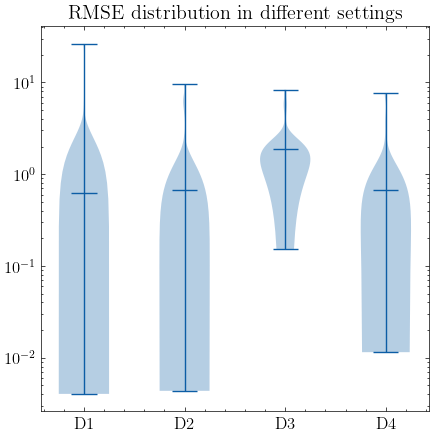

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.violinplot(
    [diff1['rmse'].to_numpy(), diff2['rmse'].to_numpy(), diff3['rmse'].to_numpy(), diff4['rmse'].to_numpy()],
    showextrema=True, showmeans=True
)

plt.title('RMSE distribution in different settings')
plt.xticks(ticks=[1, 2, 3, 4], labels=['D1', 'D2', 'D3', 'D4'])
ax.set_yscale('log')
plt.plot()

In [92]:
init_df = pd.DataFrame(
    [diff1['init'].value_counts(), diff2['init'].value_counts(),
     diff3['init'].value_counts(), diff4['init'].value_counts()], 
    index=['DIFF1', 'DIFF2', 'DIFF3', 'DIFF4']
)

<Axes: >

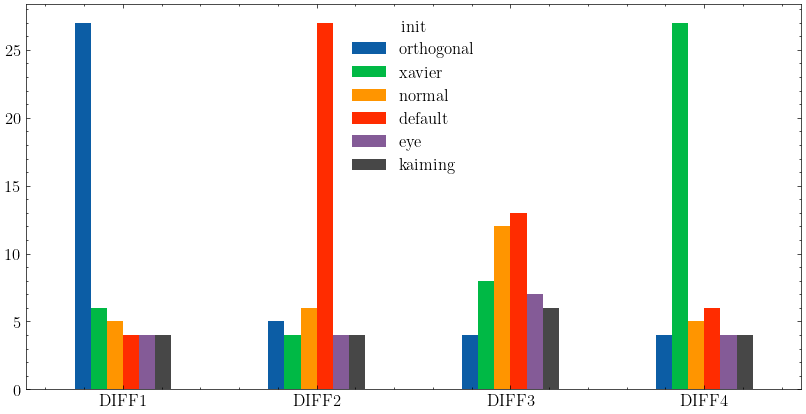

In [93]:
init_df.plot.bar(figsize=(10, 5), rot=0)

In [77]:
diff4

,rmse,L,N_D,N_I,N_LB,N_RB,W,coef,init,lr,sampling
0,0.033863,8,138,119,182,209,48,0.216498,xavier,0.002049,grid
1,0.679621,2,2008,37,102,85,64,0.823471,normal,0.888909,random
2,0.131647,2,161,26,209,193,48,0.621074,xavier,0.043312,grid
3,0.703652,6,5096,63,60,155,48,0.725641,eye,0.028684,random
4,0.700929,4,4874,69,106,136,48,0.476921,kaiming,0.121418,random
5,0.696957,6,293,119,104,92,48,0.578477,default,0.175316,grid
6,0.065142,4,411,41,42,113,32,0.318212,orthogonal,0.000034,grid
7,0.670125,6,574,82,136,118,32,0.070334,default,0.906488,random
8,0.060546,4,144,28,196,165,64,0.378338,default,0.000322,grid
9,7.625899,6,2350,83,205,173,48,0.475374,normal,0.001567,grid


In [59]:
diff1['init'].value_counts()

init
orthogonal    27
xavier         6
normal         5
default        4
eye            4
kaiming        4
Name: count, dtype: int64

In [69]:
diff1['init'].value_counts(sort=False)

init
normal         5
default        4
xavier         6
orthogonal    27
eye            4
kaiming        4
Name: count, dtype: int64

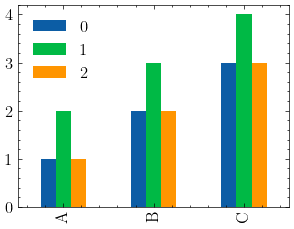

In [70]:
X = ['A','B','C']
Y = [1,2,3]
Z = [2,3,4]

df = pd.DataFrame(np.c_[Y,Z,Y], index=X)
df.plot.bar()

plt.show()

In [71]:
df

,0,1,2
A,1,2,1
B,2,3,2
C,3,4,3


<BarContainer object of 10 artists>

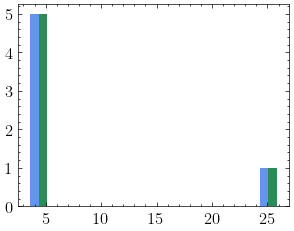

In [64]:
labels = ['default', 'eye', 'normal', 'xavier', 'kaiming', 'orthogonal']

fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(diff1['init'].value_counts())
b_heights, b_bins = np.histogram(diff2['init'].value_counts(), bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')

In [47]:
correlation, rmse_data, xlabels, ylabels = get_corr(diff1.drop(['sampling'], axis=1))
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels, k=0.5)

Instances of group...
default - 4
eye - 4
kaiming - 4
normal - 5
orthogonal - 27
xavier - 6


KeyboardInterrupt: 